# Single model pFBA predictions

In [7]:
import reframed
import pandas as pd
import numpy as np

import seaborn as sns

import os
import json
import copy

In [8]:
import functions.EGC as EGC

import functions.general_functions as general_func

#### Load data

In [9]:
all_mags_paper=general_func.read_allmags_data()
all_mags_paper.head(2)

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Coverage (%)
MAG,,,,,,,,,,,,,,,,
CH3-bin.2,Marshland,Xylan,99.19,1.61,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,Clostridium sp000230835,6175525,63,230012,5840,74.31
CH9-bin.0,Cow_Manure,Xylan,99.03,2.82,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,Bifidobacteriaceae,Bifidobacterium,NaN,2513253,38,128964,2055,65.10


#### Load models

In [10]:
directory = os.fsencode("output/GEMs/GEMs_no_constraints/")

GEMs_dict = {}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        print(filename)
        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("output/GEMs/GEMs_no_constraints/"+filename)
        continue
    else:
        continue


CH9-bin.8.xml
CH7-bin.24.xml
CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.10.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH1-bin.5.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH7-bin.25.xml
CH15-bin.4.xml
CH15-bin.18.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.7.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH13-bin.16.xml
CH13-bin.6.xml
CH1-bin.2.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH15-bin.20.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.21.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH1-bin.0.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.3.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.27.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH8-bin.20.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.0.xml
CH8-bin.12.xml
CH8-bin.2.xml
CH8-bin.11.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.4.xml
CH8-bin.5.xml
CH3-bin

In [11]:
for MAG,model in GEMs_dict.items():
    print(MAG)
    EGC.EGC_identifier(model)

CH9-bin.8
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
There are NO energy producing cycles in the model
CH7-bin.24
There are NO energy producing cycles in the model
CH7-bin.18
There are NO energy producing cycles in the model
CH15-bin.7
There are NO energy producing cycles in the model
CH13-bin.10
There are NO energy producing cycles in the model
CH13-bin.0
There are NO energy producing cycles in the model
CH1-bin.4
There are NO energy producing cycles in the model
CH1-bin.5
There are NO energy producing cycles in the model
CH13-bin.1
There are NO energy producing cycles in the model
CH13-bin.11
There are NO energy producing cycles in the model
CH15-bin.6
There are NO energy producing cycles in the model
CH7-bin.2
There are NO energy producing cycles in the model
CH7-bin.25
There are NO energy producing cycles in the model
CH15-bin.4
There are NO energy producing cycles in the model
CH15-bin.18
There are NO energy producing cycles in the m

### Define environment

**From SynCon2 to SynCon1**

"SynCon2 had the same composition, but it lacked ascorbic acid, and it had two additional trace elements (selenium and wolfram)"

Add
- Ascorbate: ascb__L

Remove
- Selenite (inorganic selenium): slnt
- (wolfram: not in BiGG database)

In [12]:
syncon2 = list(pd.read_csv("input/syncon2media_combined.csv",header=None)[0].values)

syncon1 = copy.copy(syncon2)
syncon1.remove("slnt")
syncon1.append("ascb__L")

In [13]:
substrate_composition = {"Avicel":["cellb","cell3","cell4","cell5"],
                         "PASC":["cellb","cell3","cell4","cell5"],
                         "Xylan":["xylb","xyl3","xylan4","xylan8"]}

In [15]:
syncon2_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon2_environments[substrate_name]= reframed.Environment.from_compounds(syncon2)
    for met in met_mols:
        syncon2_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

### FBA growth predictions (SynCon2)

In [16]:
community_groups = all_mags_paper.groupby(by= ["Source","Substrate"]).groups

In [18]:
FBA_growth = {}
for community, MAGs in community_groups.items(): 
    FBA_growth[community]={}
    for MAG in MAGs:
    
        print(MAG)
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        sol = reframed.FBA(model)
        
        if sol is None:
            FBA_growth[community][MAG]=None
        else:
            FBA_growth[community][MAG]=sol

CH13-bin.12
CH13-bin.14
CH13-bin.4
CH13-bin.11


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.25
CH13-bin.0
CH13-bin.17
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH13-bin.10
CH13-bin.6
CH13-bin.8
CH13-bin.19
CH13-bin.24
CH13-bin.20
CH13-bin.21


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.22
CH13-bin.16
CH15-bin.0
CH15-bin.1
CH15-bin.23
CH15-bin.7
CH15-bin.16
CH15-bin.8
CH15-bin.17
CH15-bin.22
CH15-bin.6
CH15-bin.5
CH15-bin.13
CH15-bin.10
CH15-bin.12
CH15-bin.15
CH15-bin.18
CH15-bin.2
CH15-bin.20
CH15-bin.11
CH15-bin.3
CH15-bin.4
CH14-bin.1
CH14-bin.2
CH14-bin.4
CH8-bin.22


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.17
CH8-bin.25
CH8-bin.2
CH8-bin.6


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.7
CH8-bin.5
CH8-bin.8
CH8-bin.16
CH8-bin.9
CH8-bin.21
CH8-bin.14
CH8-bin.4
CH8-bin.29
CH8-bin.12
CH8-bin.0
CH8-bin.11
CH8-bin.20
CH8-bin.27
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.8
CH7-bin.18
CH7-bin.2
CH7-bin.4
CH7-bin.1
CH7-bin.17
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH7-bin.24
CH7-bin.14
CH7-bin.21
CH7-bin.25
CH9-bin.0
CH9-bin.6
CH9-bin.1
CH9-bin.2
CH9-bin.5
CH9-bin.4
CH9-bin.8
CH1-bin.6
CH1-bin.9
CH1-bin.8
CH1-bin.3
CH1-bin.4
CH1-bin.7
CH1-bin.1
CH1-bin.10


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH1-bin.2
CH1-bin.5
CH1-bin.0
CH3-bin.2
CH3-bin.1
CH3-bin.0


**Process solution from FBA**

In [19]:
# Add the source and substrate to this data
growth_community_df = pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],pd.Series({GEM:sol.fobj for sour_sub,GEM_sol_dict in FBA_growth.items() for GEM,sol in GEM_sol_dict.items()})],axis=1)

# Change from float to False or positive
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)

# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()

# Change grows index to column
growth_community_grouped_df = growth_community_grouped_df.reset_index(level="Grows")

# Make different columns for grows and does not grow
growth_community_grouped_df = pd.concat([growth_community_grouped_df[growth_community_grouped_df["Grows"]].drop("Grows",axis=1),growth_community_grouped_df[~growth_community_grouped_df["Grows"]].drop("Grows",axis=1)],axis=1)

# Name columns
growth_community_grouped_df.columns = ["# growing","# not growing"]

growth_community_grouped_df.fillna(0,inplace=True)
growth_community_grouped_df["# growing"] = growth_community_grouped_df["# growing"].map(int)

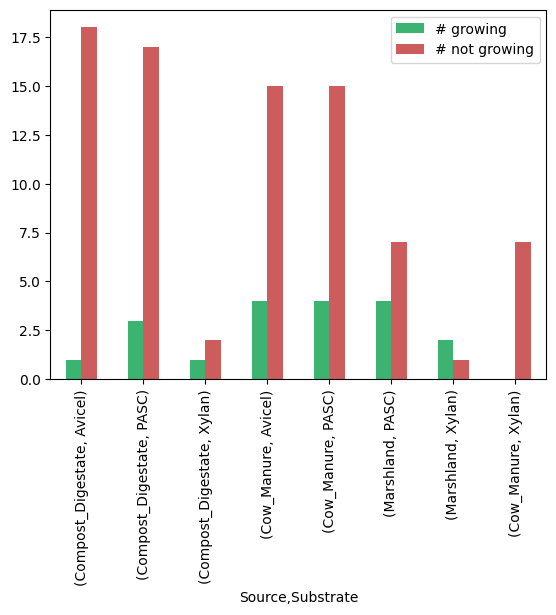

In [20]:
import matplotlib.pyplot as plt

growth_community_grouped_df.plot(kind="bar",color=['mediumseagreen','indianred'])
plt.savefig("grows_count.png",bbox_inches='tight')

### FBA product production

In [22]:
FBA_production = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]

for community, MAGs in community_groups.items(): 
    FBA_production[community]={}
    
    for MAG in MAGs:
        print(MAG)
            
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        
        FBA_production[community][MAG] = {}
        
        for met in interesting_compounds:
            if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
                FBA_production[community][MAG][met]=None
                continue
            
            sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

            if sol is None:
                FBA_production[community][MAG][met]=None
            else:
                FBA_production[community][MAG][met]=sol.fobj

CH13-bin.12
CH13-bin.14


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cellb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cell4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cell5_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.11
CH13-bin.25
CH13-bin.0
CH13-bin.17
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH13-bin.10
CH13-bin.6
CH13-bin.8
CH13-bin.19
CH13-bin.24


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.20
CH13-bin.21
CH13-bin.22
CH13-bin.16
CH15-bin.0
CH15-bin.1
CH15-bin.23
CH15-bin.7
CH15-bin.16
CH15-bin.8
CH15-bin.17
CH15-bin.22
CH15-bin.6
CH15-bin.5
CH15-bin.13
CH15-bin.10
CH15-bin.12
CH15-bin.15
CH15-bin.18
CH15-bin.2
CH15-bin.20
CH15-bin.11
CH15-bin.3
CH15-bin.4
CH14-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')


CH14-bin.2
CH14-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.22
CH8-bin.17
CH8-bin.25
CH8-bin.2
CH8-bin.6


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.7
CH8-bin.5
CH8-bin.8
CH8-bin.16
CH8-bin.9
CH8-bin.21
CH8-bin.14
CH8-bin.4
CH8-bin.29
CH8-bin.12
CH8-bin.0
CH8-bin.11
CH8-bin.20
CH8-bin.27
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.8
CH7-bin.18
CH7-bin.2
CH7-bin.4
CH7-bin.1
CH7-bin.17
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH7-bin.24
CH7-bin.14
CH7-bin.21
CH7-bin.25
CH9-bin.0
CH9-bin.6
CH9-bin.1
CH9-bin.2
CH9-bin.5
CH9-bin.4
CH9-bin.8
CH1-bin.6
CH1-bin.9
CH1-bin.8
CH1-bin.3
CH1-bin.4
CH1-bin.7


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH1-bin.1
CH1-bin.10
CH1-bin.2
CH1-bin.5
CH1-bin.0
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [23]:
# Add the source and substrate to this data
prod_sour_sub_df= pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()],axis=1)

prod_sour_sub_df.fillna(0,inplace=True)

In [26]:
# Change from floats to binary
prod_sour_sub_df_bools =  prod_sour_sub_df.iloc[:,:2]
prod_sour_sub_df_bools = pd.concat([prod_sour_sub_df_bools,prod_sour_sub_df.iloc[:,2:].map(lambda x:x>1e-6)],axis=1)

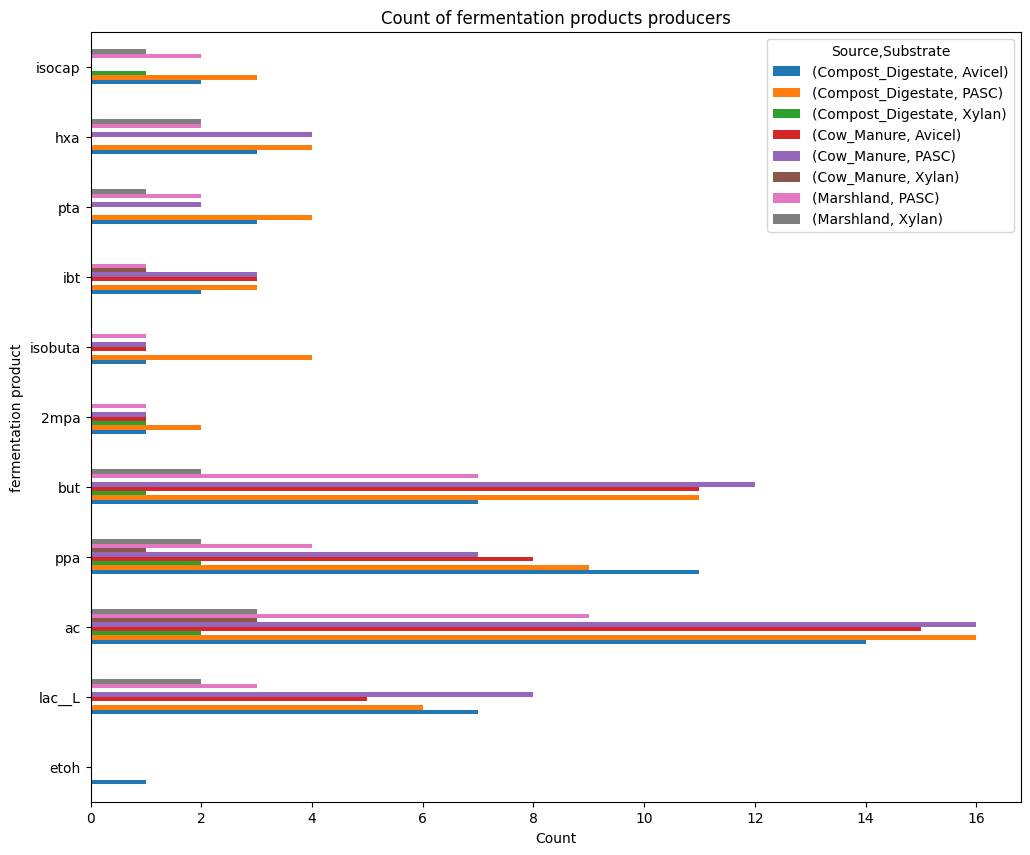

In [27]:
prod_sour_sub_df_bools.groupby(["Source","Substrate"]).sum().transpose().plot(kind="barh",figsize=(12,10))
plt.xlabel("Count")
plt.ylabel("fermentation product")
plt.title("Count of fermentation products producers")
plt.show()